AEP_Calculation
NREL
Patrick Duffy
11/11/19

In [1]:
# AEP calculation notebook
# this is a basic AEP calculation using FLORIS without any yaw optimization

In [2]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import floris.tools.visualization as vis
import floris.tools.cut_plane as cp
from floris.tools.optimization import YawOptimizationWindRose
import floris.tools.wind_rose as rose
import floris.tools.power_rose as pr
import numpy as np
import pandas as pd

In [3]:
# Instantiate the FLORIS object
fi = wfct.floris_utilities.FlorisInterface("examples\example_input.json")

# Define wind farm coordinates and layout
#wf_coordinate = [39.8283, -98.5795] # exact center of continental US
#wf_coordinate = [41.134728, -70.394570] # Massachusetts offshore
wf_coordinate = [35.236497, -120.991624] # California offshore

# Set wind farm to N_row x N_row grid with constant spacing 
# (2 x 2 grid, 7 D spacing)
D = fi.floris.farm.turbines[0].rotor_diameter
N_row = 5
spc = 7
layout_x = []
layout_y = []
for i in range(N_row):
	for k in range(N_row):
		layout_x.append(i*spc*D)
		layout_y.append(k*spc*D)
N_turb = len(layout_x)

fi.reinitialize_flow_field(layout_array=(layout_x, layout_y),wind_direction=270.0,wind_speed=8.0)
fi.calculate_wake() # must do this t 

Using default gauss deflection multipler of 1.2


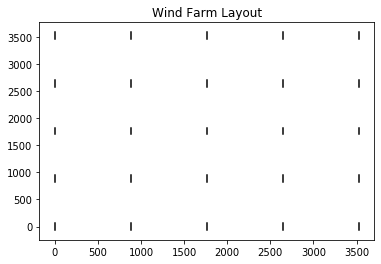

In [4]:
# plot WF layout
plot_wf_layout = True
if plot_wf_layout:
    fig, ax = plt.subplots()
    vis.plot_turbines(ax, layout_x, layout_y, yaw_angles=np.zeros(len(layout_x)), D=D)
    ax.set_title('Wind Farm Layout')



In [5]:
# set min and max yaw offsets for optimization
min_yaw = 0.0
max_yaw = 0.0 # 0 for no yaw optimization

# Define minimum and maximum wind speed for optimizing power. 
# Below minimum wind speed, assumes power is zero.
# Above maximum_ws, assume optimal yaw offsets are 0 degrees
minimum_ws = 4.0
maximum_ws = 25.0

Importing wind rose data...
Correcting negative Overhang:-2.5
Correcting negative Overhang:-7.5


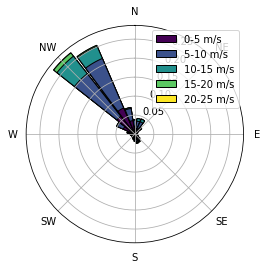

In [6]:
# ================================================================================
print('Importing wind rose data...')
# ================================================================================

# Create wind rose object and import wind rose dataframe using WIND Toolkit HSDS API.
# Alternatively, load existing .csv file with wind rose information.
calculate_new_wind_rose = True

wind_rose = rose.WindRose()

if calculate_new_wind_rose:

	wd_list = np.arange(0,360,5)
	ws_list = np.arange(0,26,1)

	df = wind_rose.import_from_wind_toolkit_hsds(wf_coordinate[0],
	                                                    wf_coordinate[1],
	                                                    ht = 100,
	                                                    wd = wd_list,
	                                                    ws = ws_list,
	                                                    limit_month = None,
	                                                    st_date = None,
	                                                    en_date = None)

else:
	df = wind_rose.load('windtoolkit_geo_center_us.p')
    
# plot wind rose
wind_rose.plot_wind_rose()
#wind_rose.save('center_us_testsave.p')

Finding baseline and optimal yaw angles in FLORIS...
Calculating baseline power...
Number of wind speed, wind direction pairs to calculate =  1872
Computing wind speed, wind direction pair 0 out of 1872: wind speed = 0.0 m/s, wind direction = 0.0 deg.
Computing wind speed, wind direction pair 1 out of 1872: wind speed = 0.0 m/s, wind direction = 5.0 deg.
Computing wind speed, wind direction pair 2 out of 1872: wind speed = 0.0 m/s, wind direction = 10.0 deg.
Computing wind speed, wind direction pair 3 out of 1872: wind speed = 0.0 m/s, wind direction = 15.0 deg.
Computing wind speed, wind direction pair 4 out of 1872: wind speed = 0.0 m/s, wind direction = 20.0 deg.
Computing wind speed, wind direction pair 5 out of 1872: wind speed = 0.0 m/s, wind direction = 25.0 deg.
Computing wind speed, wind direction pair 6 out of 1872: wind speed = 0.0 m/s, wind direction = 30.0 deg.
Computing wind speed, wind direction pair 7 out of 1872: wind speed = 0.0 m/s, wind direction = 35.0 deg.
Computi

Computing wind speed, wind direction pair 116 out of 1872: wind speed = 1.0 m/s, wind direction = 220.0 deg.
Computing wind speed, wind direction pair 117 out of 1872: wind speed = 1.0 m/s, wind direction = 225.0 deg.
Computing wind speed, wind direction pair 118 out of 1872: wind speed = 1.0 m/s, wind direction = 230.0 deg.
Computing wind speed, wind direction pair 119 out of 1872: wind speed = 1.0 m/s, wind direction = 235.0 deg.
Computing wind speed, wind direction pair 120 out of 1872: wind speed = 1.0 m/s, wind direction = 240.0 deg.
Computing wind speed, wind direction pair 121 out of 1872: wind speed = 1.0 m/s, wind direction = 245.0 deg.
Computing wind speed, wind direction pair 122 out of 1872: wind speed = 1.0 m/s, wind direction = 250.0 deg.
Computing wind speed, wind direction pair 123 out of 1872: wind speed = 1.0 m/s, wind direction = 255.0 deg.
Computing wind speed, wind direction pair 124 out of 1872: wind speed = 1.0 m/s, wind direction = 260.0 deg.
Computing wind spee

Computing wind speed, wind direction pair 252 out of 1872: wind speed = 3.0 m/s, wind direction = 180.0 deg.
Computing wind speed, wind direction pair 253 out of 1872: wind speed = 3.0 m/s, wind direction = 185.0 deg.
Computing wind speed, wind direction pair 254 out of 1872: wind speed = 3.0 m/s, wind direction = 190.0 deg.
Computing wind speed, wind direction pair 255 out of 1872: wind speed = 3.0 m/s, wind direction = 195.0 deg.
Computing wind speed, wind direction pair 256 out of 1872: wind speed = 3.0 m/s, wind direction = 200.0 deg.
Computing wind speed, wind direction pair 257 out of 1872: wind speed = 3.0 m/s, wind direction = 205.0 deg.
Computing wind speed, wind direction pair 258 out of 1872: wind speed = 3.0 m/s, wind direction = 210.0 deg.
Computing wind speed, wind direction pair 259 out of 1872: wind speed = 3.0 m/s, wind direction = 215.0 deg.
Computing wind speed, wind direction pair 260 out of 1872: wind speed = 3.0 m/s, wind direction = 220.0 deg.
Computing wind spee

C:\Users\pduffy\Documents\repos\floris\floris\simulation\wake_velocity.py:539: RuntimeWarning: invalid value encountered in sqrt
  / (8.0 * sigma_y * sigma_z / D**2)))) * totGauss)


Computing wind speed, wind direction pair 295 out of 1872: wind speed = 4.0 m/s, wind direction = 35.0 deg.
Computing wind speed, wind direction pair 296 out of 1872: wind speed = 4.0 m/s, wind direction = 40.0 deg.
Computing wind speed, wind direction pair 297 out of 1872: wind speed = 4.0 m/s, wind direction = 45.0 deg.
Computing wind speed, wind direction pair 298 out of 1872: wind speed = 4.0 m/s, wind direction = 50.0 deg.
Computing wind speed, wind direction pair 299 out of 1872: wind speed = 4.0 m/s, wind direction = 55.0 deg.
Computing wind speed, wind direction pair 300 out of 1872: wind speed = 4.0 m/s, wind direction = 60.0 deg.
Computing wind speed, wind direction pair 301 out of 1872: wind speed = 4.0 m/s, wind direction = 65.0 deg.
Computing wind speed, wind direction pair 302 out of 1872: wind speed = 4.0 m/s, wind direction = 70.0 deg.
Computing wind speed, wind direction pair 303 out of 1872: wind speed = 4.0 m/s, wind direction = 75.0 deg.
Computing wind speed, wind d

Computing wind speed, wind direction pair 372 out of 1872: wind speed = 5.0 m/s, wind direction = 60.0 deg.
Computing wind speed, wind direction pair 373 out of 1872: wind speed = 5.0 m/s, wind direction = 65.0 deg.
Computing wind speed, wind direction pair 374 out of 1872: wind speed = 5.0 m/s, wind direction = 70.0 deg.
Computing wind speed, wind direction pair 375 out of 1872: wind speed = 5.0 m/s, wind direction = 75.0 deg.
Computing wind speed, wind direction pair 376 out of 1872: wind speed = 5.0 m/s, wind direction = 80.0 deg.
Computing wind speed, wind direction pair 377 out of 1872: wind speed = 5.0 m/s, wind direction = 85.0 deg.
Computing wind speed, wind direction pair 378 out of 1872: wind speed = 5.0 m/s, wind direction = 90.0 deg.
Computing wind speed, wind direction pair 379 out of 1872: wind speed = 5.0 m/s, wind direction = 95.0 deg.
Computing wind speed, wind direction pair 380 out of 1872: wind speed = 5.0 m/s, wind direction = 100.0 deg.
Computing wind speed, wind 

Computing wind speed, wind direction pair 449 out of 1872: wind speed = 6.0 m/s, wind direction = 85.0 deg.
Computing wind speed, wind direction pair 450 out of 1872: wind speed = 6.0 m/s, wind direction = 90.0 deg.
Computing wind speed, wind direction pair 451 out of 1872: wind speed = 6.0 m/s, wind direction = 95.0 deg.
Computing wind speed, wind direction pair 452 out of 1872: wind speed = 6.0 m/s, wind direction = 100.0 deg.
Computing wind speed, wind direction pair 453 out of 1872: wind speed = 6.0 m/s, wind direction = 105.0 deg.
Computing wind speed, wind direction pair 454 out of 1872: wind speed = 6.0 m/s, wind direction = 110.0 deg.
Computing wind speed, wind direction pair 455 out of 1872: wind speed = 6.0 m/s, wind direction = 115.0 deg.
Computing wind speed, wind direction pair 456 out of 1872: wind speed = 6.0 m/s, wind direction = 120.0 deg.
Computing wind speed, wind direction pair 457 out of 1872: wind speed = 6.0 m/s, wind direction = 125.0 deg.
Computing wind speed, 

Computing wind speed, wind direction pair 527 out of 1872: wind speed = 7.0 m/s, wind direction = 115.0 deg.
Computing wind speed, wind direction pair 528 out of 1872: wind speed = 7.0 m/s, wind direction = 120.0 deg.
Computing wind speed, wind direction pair 529 out of 1872: wind speed = 7.0 m/s, wind direction = 125.0 deg.
Computing wind speed, wind direction pair 530 out of 1872: wind speed = 7.0 m/s, wind direction = 130.0 deg.
Computing wind speed, wind direction pair 531 out of 1872: wind speed = 7.0 m/s, wind direction = 135.0 deg.
Computing wind speed, wind direction pair 532 out of 1872: wind speed = 7.0 m/s, wind direction = 140.0 deg.
Computing wind speed, wind direction pair 533 out of 1872: wind speed = 7.0 m/s, wind direction = 145.0 deg.
Computing wind speed, wind direction pair 534 out of 1872: wind speed = 7.0 m/s, wind direction = 150.0 deg.
Computing wind speed, wind direction pair 535 out of 1872: wind speed = 7.0 m/s, wind direction = 155.0 deg.
Computing wind spee

Computing wind speed, wind direction pair 603 out of 1872: wind speed = 8.0 m/s, wind direction = 135.0 deg.
Computing wind speed, wind direction pair 604 out of 1872: wind speed = 8.0 m/s, wind direction = 140.0 deg.
Computing wind speed, wind direction pair 605 out of 1872: wind speed = 8.0 m/s, wind direction = 145.0 deg.
Computing wind speed, wind direction pair 606 out of 1872: wind speed = 8.0 m/s, wind direction = 150.0 deg.
Computing wind speed, wind direction pair 607 out of 1872: wind speed = 8.0 m/s, wind direction = 155.0 deg.
Computing wind speed, wind direction pair 608 out of 1872: wind speed = 8.0 m/s, wind direction = 160.0 deg.
Computing wind speed, wind direction pair 609 out of 1872: wind speed = 8.0 m/s, wind direction = 165.0 deg.
Computing wind speed, wind direction pair 610 out of 1872: wind speed = 8.0 m/s, wind direction = 170.0 deg.
Computing wind speed, wind direction pair 611 out of 1872: wind speed = 8.0 m/s, wind direction = 175.0 deg.
Computing wind spee

Computing wind speed, wind direction pair 680 out of 1872: wind speed = 9.0 m/s, wind direction = 160.0 deg.
Computing wind speed, wind direction pair 681 out of 1872: wind speed = 9.0 m/s, wind direction = 165.0 deg.
Computing wind speed, wind direction pair 682 out of 1872: wind speed = 9.0 m/s, wind direction = 170.0 deg.
Computing wind speed, wind direction pair 683 out of 1872: wind speed = 9.0 m/s, wind direction = 175.0 deg.
Computing wind speed, wind direction pair 684 out of 1872: wind speed = 9.0 m/s, wind direction = 180.0 deg.
Computing wind speed, wind direction pair 685 out of 1872: wind speed = 9.0 m/s, wind direction = 185.0 deg.
Computing wind speed, wind direction pair 686 out of 1872: wind speed = 9.0 m/s, wind direction = 190.0 deg.
Computing wind speed, wind direction pair 687 out of 1872: wind speed = 9.0 m/s, wind direction = 195.0 deg.
Computing wind speed, wind direction pair 688 out of 1872: wind speed = 9.0 m/s, wind direction = 200.0 deg.
Computing wind spee

Computing wind speed, wind direction pair 756 out of 1872: wind speed = 10.0 m/s, wind direction = 180.0 deg.
Computing wind speed, wind direction pair 757 out of 1872: wind speed = 10.0 m/s, wind direction = 185.0 deg.
Computing wind speed, wind direction pair 758 out of 1872: wind speed = 10.0 m/s, wind direction = 190.0 deg.
Computing wind speed, wind direction pair 759 out of 1872: wind speed = 10.0 m/s, wind direction = 195.0 deg.
Computing wind speed, wind direction pair 760 out of 1872: wind speed = 10.0 m/s, wind direction = 200.0 deg.
Computing wind speed, wind direction pair 761 out of 1872: wind speed = 10.0 m/s, wind direction = 205.0 deg.
Computing wind speed, wind direction pair 762 out of 1872: wind speed = 10.0 m/s, wind direction = 210.0 deg.
Computing wind speed, wind direction pair 763 out of 1872: wind speed = 10.0 m/s, wind direction = 215.0 deg.
Computing wind speed, wind direction pair 764 out of 1872: wind speed = 10.0 m/s, wind direction = 220.0 deg.
Computing 

Computing wind speed, wind direction pair 831 out of 1872: wind speed = 11.0 m/s, wind direction = 195.0 deg.
Computing wind speed, wind direction pair 832 out of 1872: wind speed = 11.0 m/s, wind direction = 200.0 deg.
Computing wind speed, wind direction pair 833 out of 1872: wind speed = 11.0 m/s, wind direction = 205.0 deg.
Computing wind speed, wind direction pair 834 out of 1872: wind speed = 11.0 m/s, wind direction = 210.0 deg.
Computing wind speed, wind direction pair 835 out of 1872: wind speed = 11.0 m/s, wind direction = 215.0 deg.
Computing wind speed, wind direction pair 836 out of 1872: wind speed = 11.0 m/s, wind direction = 220.0 deg.
Computing wind speed, wind direction pair 837 out of 1872: wind speed = 11.0 m/s, wind direction = 225.0 deg.
Computing wind speed, wind direction pair 838 out of 1872: wind speed = 11.0 m/s, wind direction = 230.0 deg.
Computing wind speed, wind direction pair 839 out of 1872: wind speed = 11.0 m/s, wind direction = 235.0 deg.
Computing 

Computing wind speed, wind direction pair 907 out of 1872: wind speed = 12.0 m/s, wind direction = 215.0 deg.
Computing wind speed, wind direction pair 908 out of 1872: wind speed = 12.0 m/s, wind direction = 220.0 deg.
Computing wind speed, wind direction pair 909 out of 1872: wind speed = 12.0 m/s, wind direction = 225.0 deg.
Computing wind speed, wind direction pair 910 out of 1872: wind speed = 12.0 m/s, wind direction = 230.0 deg.
Computing wind speed, wind direction pair 911 out of 1872: wind speed = 12.0 m/s, wind direction = 235.0 deg.
Computing wind speed, wind direction pair 912 out of 1872: wind speed = 12.0 m/s, wind direction = 240.0 deg.
Computing wind speed, wind direction pair 913 out of 1872: wind speed = 12.0 m/s, wind direction = 245.0 deg.
Computing wind speed, wind direction pair 914 out of 1872: wind speed = 12.0 m/s, wind direction = 250.0 deg.
Computing wind speed, wind direction pair 915 out of 1872: wind speed = 12.0 m/s, wind direction = 255.0 deg.
Computing 

Computing wind speed, wind direction pair 982 out of 1872: wind speed = 13.0 m/s, wind direction = 230.0 deg.
Computing wind speed, wind direction pair 983 out of 1872: wind speed = 13.0 m/s, wind direction = 235.0 deg.
Computing wind speed, wind direction pair 984 out of 1872: wind speed = 13.0 m/s, wind direction = 240.0 deg.
Computing wind speed, wind direction pair 985 out of 1872: wind speed = 13.0 m/s, wind direction = 245.0 deg.
Computing wind speed, wind direction pair 986 out of 1872: wind speed = 13.0 m/s, wind direction = 250.0 deg.
Computing wind speed, wind direction pair 987 out of 1872: wind speed = 13.0 m/s, wind direction = 255.0 deg.
Computing wind speed, wind direction pair 988 out of 1872: wind speed = 13.0 m/s, wind direction = 260.0 deg.
Computing wind speed, wind direction pair 989 out of 1872: wind speed = 13.0 m/s, wind direction = 265.0 deg.
Computing wind speed, wind direction pair 990 out of 1872: wind speed = 13.0 m/s, wind direction = 270.0 deg.
Computing 

Computing wind speed, wind direction pair 1057 out of 1872: wind speed = 14.0 m/s, wind direction = 245.0 deg.
Computing wind speed, wind direction pair 1058 out of 1872: wind speed = 14.0 m/s, wind direction = 250.0 deg.
Computing wind speed, wind direction pair 1059 out of 1872: wind speed = 14.0 m/s, wind direction = 255.0 deg.
Computing wind speed, wind direction pair 1060 out of 1872: wind speed = 14.0 m/s, wind direction = 260.0 deg.
Computing wind speed, wind direction pair 1061 out of 1872: wind speed = 14.0 m/s, wind direction = 265.0 deg.
Computing wind speed, wind direction pair 1062 out of 1872: wind speed = 14.0 m/s, wind direction = 270.0 deg.
Computing wind speed, wind direction pair 1063 out of 1872: wind speed = 14.0 m/s, wind direction = 275.0 deg.
Computing wind speed, wind direction pair 1064 out of 1872: wind speed = 14.0 m/s, wind direction = 280.0 deg.
Computing wind speed, wind direction pair 1065 out of 1872: wind speed = 14.0 m/s, wind direction = 285.0 deg.
C

Computing wind speed, wind direction pair 1133 out of 1872: wind speed = 15.0 m/s, wind direction = 265.0 deg.
Computing wind speed, wind direction pair 1134 out of 1872: wind speed = 15.0 m/s, wind direction = 270.0 deg.
Computing wind speed, wind direction pair 1135 out of 1872: wind speed = 15.0 m/s, wind direction = 275.0 deg.
Computing wind speed, wind direction pair 1136 out of 1872: wind speed = 15.0 m/s, wind direction = 280.0 deg.
Computing wind speed, wind direction pair 1137 out of 1872: wind speed = 15.0 m/s, wind direction = 285.0 deg.
Computing wind speed, wind direction pair 1138 out of 1872: wind speed = 15.0 m/s, wind direction = 290.0 deg.
Computing wind speed, wind direction pair 1139 out of 1872: wind speed = 15.0 m/s, wind direction = 295.0 deg.
Computing wind speed, wind direction pair 1140 out of 1872: wind speed = 15.0 m/s, wind direction = 300.0 deg.
Computing wind speed, wind direction pair 1141 out of 1872: wind speed = 15.0 m/s, wind direction = 305.0 deg.
C

Computing wind speed, wind direction pair 1208 out of 1872: wind speed = 16.0 m/s, wind direction = 280.0 deg.
Computing wind speed, wind direction pair 1209 out of 1872: wind speed = 16.0 m/s, wind direction = 285.0 deg.
Computing wind speed, wind direction pair 1210 out of 1872: wind speed = 16.0 m/s, wind direction = 290.0 deg.
Computing wind speed, wind direction pair 1211 out of 1872: wind speed = 16.0 m/s, wind direction = 295.0 deg.
Computing wind speed, wind direction pair 1212 out of 1872: wind speed = 16.0 m/s, wind direction = 300.0 deg.
Computing wind speed, wind direction pair 1213 out of 1872: wind speed = 16.0 m/s, wind direction = 305.0 deg.
Computing wind speed, wind direction pair 1214 out of 1872: wind speed = 16.0 m/s, wind direction = 310.0 deg.
Computing wind speed, wind direction pair 1215 out of 1872: wind speed = 16.0 m/s, wind direction = 315.0 deg.
Computing wind speed, wind direction pair 1216 out of 1872: wind speed = 16.0 m/s, wind direction = 320.0 deg.
C

Computing wind speed, wind direction pair 1283 out of 1872: wind speed = 17.0 m/s, wind direction = 295.0 deg.
Computing wind speed, wind direction pair 1284 out of 1872: wind speed = 17.0 m/s, wind direction = 300.0 deg.
Computing wind speed, wind direction pair 1285 out of 1872: wind speed = 17.0 m/s, wind direction = 305.0 deg.
Computing wind speed, wind direction pair 1286 out of 1872: wind speed = 17.0 m/s, wind direction = 310.0 deg.
Computing wind speed, wind direction pair 1287 out of 1872: wind speed = 17.0 m/s, wind direction = 315.0 deg.
Computing wind speed, wind direction pair 1288 out of 1872: wind speed = 17.0 m/s, wind direction = 320.0 deg.
Computing wind speed, wind direction pair 1289 out of 1872: wind speed = 17.0 m/s, wind direction = 325.0 deg.
Computing wind speed, wind direction pair 1290 out of 1872: wind speed = 17.0 m/s, wind direction = 330.0 deg.
Computing wind speed, wind direction pair 1291 out of 1872: wind speed = 17.0 m/s, wind direction = 335.0 deg.
C

Computing wind speed, wind direction pair 1360 out of 1872: wind speed = 18.0 m/s, wind direction = 320.0 deg.
Computing wind speed, wind direction pair 1361 out of 1872: wind speed = 18.0 m/s, wind direction = 325.0 deg.
Computing wind speed, wind direction pair 1362 out of 1872: wind speed = 18.0 m/s, wind direction = 330.0 deg.
Computing wind speed, wind direction pair 1363 out of 1872: wind speed = 18.0 m/s, wind direction = 335.0 deg.
Computing wind speed, wind direction pair 1364 out of 1872: wind speed = 18.0 m/s, wind direction = 340.0 deg.
Computing wind speed, wind direction pair 1365 out of 1872: wind speed = 18.0 m/s, wind direction = 345.0 deg.
Computing wind speed, wind direction pair 1366 out of 1872: wind speed = 18.0 m/s, wind direction = 350.0 deg.
Computing wind speed, wind direction pair 1367 out of 1872: wind speed = 18.0 m/s, wind direction = 355.0 deg.
Computing wind speed, wind direction pair 1368 out of 1872: wind speed = 19.0 m/s, wind direction = 0.0 deg.
Com

Computing wind speed, wind direction pair 1435 out of 1872: wind speed = 19.0 m/s, wind direction = 335.0 deg.
Computing wind speed, wind direction pair 1436 out of 1872: wind speed = 19.0 m/s, wind direction = 340.0 deg.
Computing wind speed, wind direction pair 1437 out of 1872: wind speed = 19.0 m/s, wind direction = 345.0 deg.
Computing wind speed, wind direction pair 1438 out of 1872: wind speed = 19.0 m/s, wind direction = 350.0 deg.
Computing wind speed, wind direction pair 1439 out of 1872: wind speed = 19.0 m/s, wind direction = 355.0 deg.
Computing wind speed, wind direction pair 1440 out of 1872: wind speed = 20.0 m/s, wind direction = 0.0 deg.
Computing wind speed, wind direction pair 1441 out of 1872: wind speed = 20.0 m/s, wind direction = 5.0 deg.
Computing wind speed, wind direction pair 1442 out of 1872: wind speed = 20.0 m/s, wind direction = 10.0 deg.
Computing wind speed, wind direction pair 1443 out of 1872: wind speed = 20.0 m/s, wind direction = 15.0 deg.
Computi

Computing wind speed, wind direction pair 1510 out of 1872: wind speed = 20.0 m/s, wind direction = 350.0 deg.
Computing wind speed, wind direction pair 1511 out of 1872: wind speed = 20.0 m/s, wind direction = 355.0 deg.
Computing wind speed, wind direction pair 1512 out of 1872: wind speed = 21.0 m/s, wind direction = 0.0 deg.
Computing wind speed, wind direction pair 1513 out of 1872: wind speed = 21.0 m/s, wind direction = 5.0 deg.
Computing wind speed, wind direction pair 1514 out of 1872: wind speed = 21.0 m/s, wind direction = 10.0 deg.
Computing wind speed, wind direction pair 1515 out of 1872: wind speed = 21.0 m/s, wind direction = 15.0 deg.
Computing wind speed, wind direction pair 1516 out of 1872: wind speed = 21.0 m/s, wind direction = 20.0 deg.
Computing wind speed, wind direction pair 1517 out of 1872: wind speed = 21.0 m/s, wind direction = 25.0 deg.
Computing wind speed, wind direction pair 1518 out of 1872: wind speed = 21.0 m/s, wind direction = 30.0 deg.
Computing 

Computing wind speed, wind direction pair 1586 out of 1872: wind speed = 22.0 m/s, wind direction = 10.0 deg.
Computing wind speed, wind direction pair 1587 out of 1872: wind speed = 22.0 m/s, wind direction = 15.0 deg.
Computing wind speed, wind direction pair 1588 out of 1872: wind speed = 22.0 m/s, wind direction = 20.0 deg.
Computing wind speed, wind direction pair 1589 out of 1872: wind speed = 22.0 m/s, wind direction = 25.0 deg.
Computing wind speed, wind direction pair 1590 out of 1872: wind speed = 22.0 m/s, wind direction = 30.0 deg.
Computing wind speed, wind direction pair 1591 out of 1872: wind speed = 22.0 m/s, wind direction = 35.0 deg.
Computing wind speed, wind direction pair 1592 out of 1872: wind speed = 22.0 m/s, wind direction = 40.0 deg.
Computing wind speed, wind direction pair 1593 out of 1872: wind speed = 22.0 m/s, wind direction = 45.0 deg.
Computing wind speed, wind direction pair 1594 out of 1872: wind speed = 22.0 m/s, wind direction = 50.0 deg.
Computing 

Computing wind speed, wind direction pair 1661 out of 1872: wind speed = 23.0 m/s, wind direction = 25.0 deg.
Computing wind speed, wind direction pair 1662 out of 1872: wind speed = 23.0 m/s, wind direction = 30.0 deg.
Computing wind speed, wind direction pair 1663 out of 1872: wind speed = 23.0 m/s, wind direction = 35.0 deg.
Computing wind speed, wind direction pair 1664 out of 1872: wind speed = 23.0 m/s, wind direction = 40.0 deg.
Computing wind speed, wind direction pair 1665 out of 1872: wind speed = 23.0 m/s, wind direction = 45.0 deg.
Computing wind speed, wind direction pair 1666 out of 1872: wind speed = 23.0 m/s, wind direction = 50.0 deg.
Computing wind speed, wind direction pair 1667 out of 1872: wind speed = 23.0 m/s, wind direction = 55.0 deg.
Computing wind speed, wind direction pair 1668 out of 1872: wind speed = 23.0 m/s, wind direction = 60.0 deg.
Computing wind speed, wind direction pair 1669 out of 1872: wind speed = 23.0 m/s, wind direction = 65.0 deg.
Computing 

Computing wind speed, wind direction pair 1737 out of 1872: wind speed = 24.0 m/s, wind direction = 45.0 deg.
Computing wind speed, wind direction pair 1738 out of 1872: wind speed = 24.0 m/s, wind direction = 50.0 deg.
Computing wind speed, wind direction pair 1739 out of 1872: wind speed = 24.0 m/s, wind direction = 55.0 deg.
Computing wind speed, wind direction pair 1740 out of 1872: wind speed = 24.0 m/s, wind direction = 60.0 deg.
Computing wind speed, wind direction pair 1741 out of 1872: wind speed = 24.0 m/s, wind direction = 65.0 deg.
Computing wind speed, wind direction pair 1742 out of 1872: wind speed = 24.0 m/s, wind direction = 70.0 deg.
Computing wind speed, wind direction pair 1743 out of 1872: wind speed = 24.0 m/s, wind direction = 75.0 deg.
Computing wind speed, wind direction pair 1744 out of 1872: wind speed = 24.0 m/s, wind direction = 80.0 deg.
Computing wind speed, wind direction pair 1745 out of 1872: wind speed = 24.0 m/s, wind direction = 85.0 deg.
Computing 

Computing wind speed, wind direction pair 1813 out of 1872: wind speed = 25.0 m/s, wind direction = 65.0 deg.
Computing wind speed, wind direction pair 1814 out of 1872: wind speed = 25.0 m/s, wind direction = 70.0 deg.
Computing wind speed, wind direction pair 1815 out of 1872: wind speed = 25.0 m/s, wind direction = 75.0 deg.
Computing wind speed, wind direction pair 1816 out of 1872: wind speed = 25.0 m/s, wind direction = 80.0 deg.
Computing wind speed, wind direction pair 1817 out of 1872: wind speed = 25.0 m/s, wind direction = 85.0 deg.
Computing wind speed, wind direction pair 1818 out of 1872: wind speed = 25.0 m/s, wind direction = 90.0 deg.
Computing wind speed, wind direction pair 1819 out of 1872: wind speed = 25.0 m/s, wind direction = 95.0 deg.
Computing wind speed, wind direction pair 1820 out of 1872: wind speed = 25.0 m/s, wind direction = 100.0 deg.
Computing wind speed, wind direction pair 1821 out of 1872: wind speed = 25.0 m/s, wind direction = 105.0 deg.
Computin

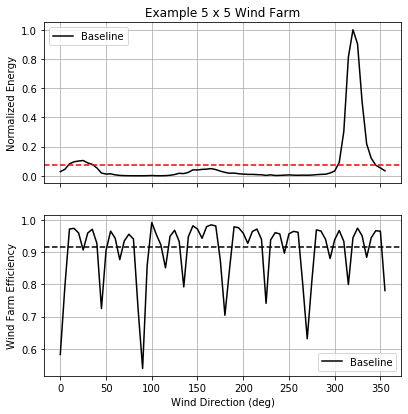

In [7]:
# =============================================================================
print('Finding baseline and optimal yaw angles in FLORIS...')
# =============================================================================

# Instantiate the Optimization object
yaw_opt = YawOptimizationWindRose(fi, df.wd, df.ws,
                               minimum_yaw_angle=min_yaw,
                               maximum_yaw_angle=max_yaw,
                               minimum_ws=minimum_ws,
                               maximum_ws=maximum_ws)

# Determine baseline power with and without wakes
df_base = yaw_opt.calc_baseline_power()


# combine wind farm-level power into one dataframe
df_power = pd.DataFrame({'ws':df.ws,'wd':df.wd, \
    'freq_val':df.freq_val,'power_no_wake':df_base.power_no_wake, \
    'power_baseline':df_base.power_baseline})

# Set up the power rose
df_turbine_power_no_wake = pd.DataFrame([list(row) for row in df_base['turbine_power_no_wake']],columns=[str(i) for i in range(1,N_turb+1)])
df_turbine_power_no_wake['ws'] = df.ws
df_turbine_power_no_wake['wd'] = df.wd
df_turbine_power_baseline = pd.DataFrame([list(row) for row in df_base['turbine_power_baseline']],columns=[str(i) for i in range(1,N_turb+1)])
df_turbine_power_baseline['ws'] = df.ws
df_turbine_power_baseline['wd'] = df.wd

case_name = 'Example '+str(N_row)+' x '+str(N_row)+ ' Wind Farm'
power_rose = pr.PowerRose(case_name, df_power, df_turbine_power_no_wake, df_turbine_power_baseline)

# Display AEP analysis
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(6.4, 6.5))
power_rose.plot_by_direction(axarr)
power_rose.report()

plt.show()

In [8]:
# It takes approx. 5 min for me to run this notebook with 25 turbines and fetching wind data from WTK - Patrick


#df.columns # wind data 
#df_base.columns
#df_base['turbine_power_baseline']
#df_base['turbine_power_no_wake']